# Hallway Experiments in Curriculum Learning

-------------------------------


Salkey, Jayson

28/06/2018

-----------------------------------


## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 6-7 + 9-11

# Setup

### Import Useful Libraries

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from collections import namedtuple

### Set options

In [38]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=1)

### Helper functions

In [39]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  vmin = np.min(values)
  vmax = np.max(values)
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

## Assignment 2 [50pts in total + 10 BONUS pts]

### A grid world

In [40]:
class Grid(object):

  def __init__(self, tabular=True, vision_size=1, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -5, -1, -1, -1, -1, -6, -1, -1, -1, -1, 10, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
      
    
    self._start_state = (3, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(3, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==10)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-5)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-6)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = 0.98
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      #reward = (new_y + new_x) / np.sum(self._layout.shape)
      #print (new_y + new_x) / np.sum(self._layout.shape)
      reward = float((new_y + new_x)) / float(np.sum(self._layout.shape))
      #print float((new_y + new_x)) / float(np.sum(self._layout.shape))
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### A hallway world

In [41]:
class Hallway(object):

  def __init__(self, goal_loc, tabular=True, vision_size=1, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    
    self.goal_loc_r = goal_loc[0]
    self.goal_loc_c = goal_loc[1]
    
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
    
    self._layout[self.goal_loc_r,self.goal_loc_c] = 5
    
    self._start_state = (3, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(3, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==5)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = 0.98
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      #reward = (new_y + new_x) / np.sum(self._layout.shape)
      #print (new_y + new_x) / np.sum(self._layout.shape)
      reward = float((new_y + new_x)) / float(np.sum(self._layout.shape))
      #print float((new_y + new_x)) / float(np.sum(self._layout.shape))
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-1` for bumping into a wall, `+10` for reaching the goal, and `(x + y)/(height + width)` otherwise, which encourages the agent to go right and down.  The episode ends when the agent reaches the goal.  At the end of the left-most two corridors, there are distractor 'goals' (marked `D`) that give a reward of $-5$ and $-6$, and then also terminate the episode.  The discount, on continuing steps, is $\gamma = 0.98$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

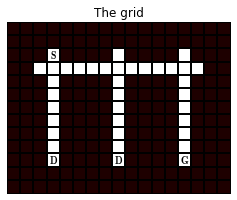

In [42]:
grid = Grid()
grid.plot_grid()

### The Hallway(s)

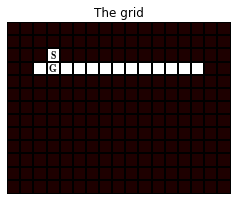

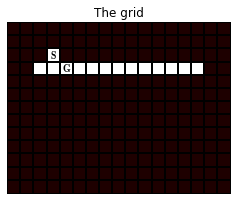

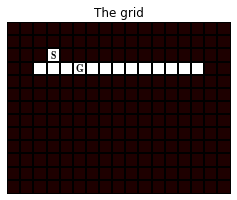

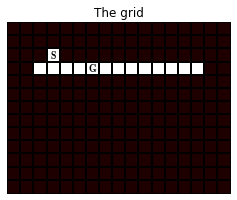

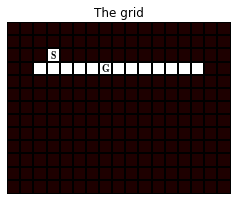

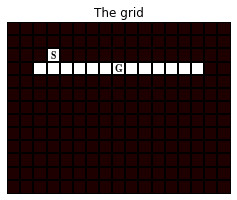

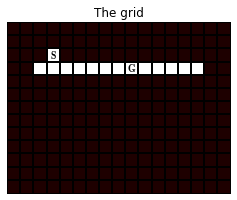

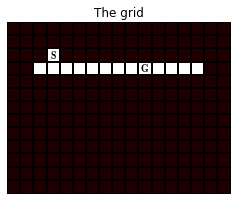

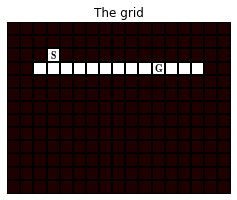

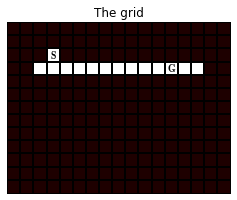

In [43]:
# goal_loc has format (row, col)
tasks = []
for x in xrange(0,10):
  tasks.append(Hallway(goal_loc = (3, 3+x)))
  tasks[-1].plot_grid()


## Implement agents
**[10 pts]** In the next code cell, implement an agent that uses **tabular Sarsa** to learn action values.  The agent should act according to an $\epsilon$-greedy policy with respect to its action values.

The agent will be initialized with:
```
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              grid.get_obs())
```

In [44]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
#     if double:
#       self._q2 = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

#     self._double = double
    self._last_action = 0
   
  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q):
    return epsilon_greedy(q, 0.1)
  
  @property
  def q_values(self):
#     if self._double:
#       return (self._q + self._q2)/2
#     else:
    return self._q

  def step(self, r, g, s):
#     if self._double:
#       next_action = self._behaviour_policy(self.q_values[s,:])
#       if np.random.random() <= 0.5:
#         expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q2[s,:])
#         self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
#         #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q2[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
#       else:
#         expectation = np.sum(self._target_policy(self._q2[s,:], next_action) * self._q[s,:])
#         self._q2[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q2[self._s,self._last_action])   
#         #self._q2[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q2[s,:], next_action))] - self._q2[self._s,self._last_action])    
#       self._s = s
#       self._last_action = next_action
#       return self._last_action
#     else:
    next_action = self._behaviour_policy(self._q[s,:])
    # This is expected sarsa, but still functions as expected.
    expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q[s,:])
    self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
    #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
    self._s = s
    self._last_action = next_action
    return self._last_action

**[20 pts]** Implement an agent that uses **neural Sarsa** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

You are allowed, but not mandated, to use TensorFlow to implement this agent.  (The network is small enough that you can also use numpy, but then you have to implement your own backprop.)  Please document the code clearly, especially on non-trivial operations.

In [45]:
class NeuralSarsa(object):

  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, step_size=0.01):
    tf.reset_default_graph()
    self._prev_action = 0
    self._step = step_size
    self._num_features = number_of_features
    self._num_action = number_of_actions
    self._num_hidden = number_of_hidden
    self._s = initial_state
    self._s = np.reshape(self._s, (1,-1))
    
    self.handleTF()
  
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor = tf.placeholder(tf.float32)
    self.disTensor = tf.placeholder(tf.float32)
    self.nqTensor = tf.placeholder(tf.float32)
    self.actionTensor = tf.placeholder(tf.int32)
    self.stateTensor = tf.placeholder(tf.float32, shape=(1,self._num_features))
    self._dense_1 = tf.layers.dense(self.stateTensor,
                                    self._num_hidden, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2 = tf.layers.dense(self._dense_1,
                                    self._num_action, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q = tf.reshape(self._dense_2, (self._num_action,))    
    cost = tf.losses.mean_squared_error(self.rewTensor + self.disTensor*self.nqTensor, self._q[self.actionTensor])
    self._opt = tf.train.RMSPropOptimizer(self._step).minimize(cost)
    
    init = tf.global_variables_initializer()
    self._sess.run(init)

  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q):
    return epsilon_greedy(q, 0.1)

  def q(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    return self._sess.run(self._q, {self.stateTensor: obs})
  
  def step(self, r, g, s):
    # This function should return an action
    q_nxtState = np.reshape(self.q(s), (-1,))
    next_action = self._behaviour_policy(q_nxtState)
    target = self._target_policy(q_nxtState, next_action)
    target = np.random.choice(np.where(np.max(target) == target)[0])
    
    # Optimiser
    
    vob = q_nxtState[target]
    self._sess.run(self._opt,{
        self.nqTensor: vob,
        self.rewTensor: r,
        self.disTensor: g,
        self.actionTensor: self._prev_action,
        self.stateTensor: self._s})
    
    self._s = np.reshape(self._s, (1,-1))
    self._prev_action = next_action
    return next_action

# Analyse Results

### Run the cells below to train the tabular and neural SARSA agents and to generate plots.

This trains the agents the Grid problem with an epsilon of 0.1.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \sum_a \pi(a|s) q(s, a)$.

In [10]:
grid = Grid()
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              initial_state=grid.get_obs())
run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.566666666667
0


0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0

0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0

0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.23333333

0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.33333333333

0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0


0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.3
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0

0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4


0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.366666666667
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.16

0.533333333333
0
0.5
0
0.466666666667
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.5
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.5
0
0.466666666667
0
0.5
0
0.466666666667
0
0.5
0
0.466666666667
0
0.5
0
0.466666666667
0
0.5
0
0.466666666667
0
0.5
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.4
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.4
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.4
0
0.433333333333
0
0.466666666667
0
0.433333333333
0
0.466666666667
0
0.433333333333

0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2

0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.3
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.23333

0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.23333

0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0


0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.3333

0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.3
0
0.266666666667
0
0.233333333333
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0
0.2
0
0.233333333333
0
0.2
0
0.166666666667
0
0.2
0
0.166666666667
0

0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666

0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.666666666667
0
0.7
0
0.733333333333
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0

0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667

0.166666666667
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333

0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.366666666667
0
0.4
0
0.433333333333
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333333333
0
0.2
0
0.233333333333
0
0.266666666667
0
0.3
0
0.333333333333
0
0.366666666667
0
0.4
0
0.433333333333
0
0.466666666667
0
0.5
0
0.533333333333
0
0.566666666667
0
0.6
0
0.566666666667
0
0.6
0
0.633333333333
0
0.666666666667
0
0.7
0
0.733333

KeyboardInterrupt: 

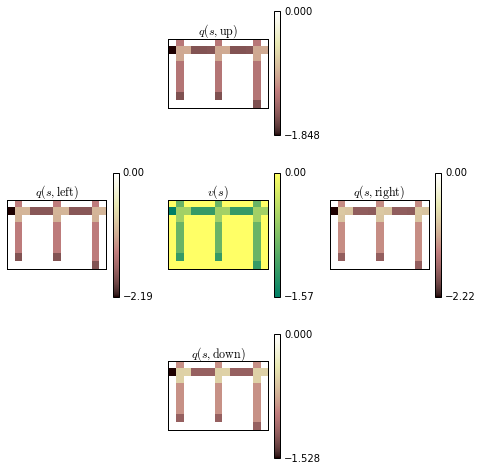

In [0]:
vision_size = 1
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

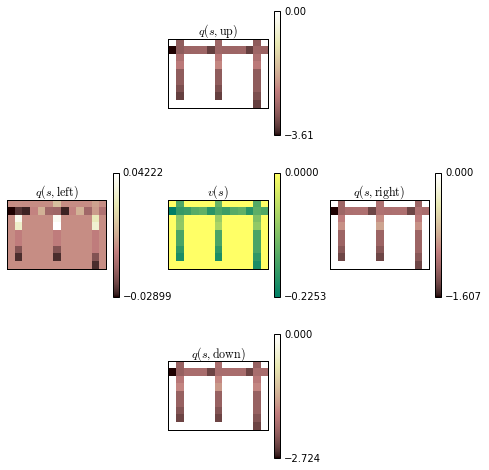

In [0]:
vision_size = 2
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

In [54]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
def run_episode(env, agent, number_of_episodes):
    # Mean Reward across all the episodes( aka all steps )
    mean_reward = 0.
    
    # Mean Duration per episode
    mean_duration = 0.
    
    # List of (Total Reward Per Epsiode)/(Duration)
    signal_per_episode = np.zeros((1, number_of_episodes))
    
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    
    episodes_completed = 0
    total_reward_per_episode = 0.
    
    start_time = time.time()
    
    i = 0.
    while episodes_completed != number_of_episodes:
      reward, discount, next_state = env.step(action)
      total_reward_per_episode += reward
      
      if discount == 0:
        duration = time.time() - start_time
        signal_per_episode[0,episodes_completed] = (total_reward_per_episode/duration)
        
        episodes_completed += 1
        mean_duration += (duration - mean_duration)/(episodes_completed)
        
        start_time = time.time()
        total_reward_per_episode = 0.
        
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)
      i += 1.
    
    mean_signal = np.mean(signal_per_episode)
    return mean_signal, signal_per_episode

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  vmin = np.min(values)
  vmax = np.max(values)
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

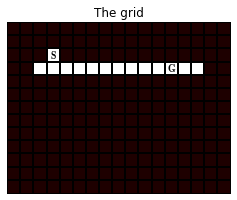

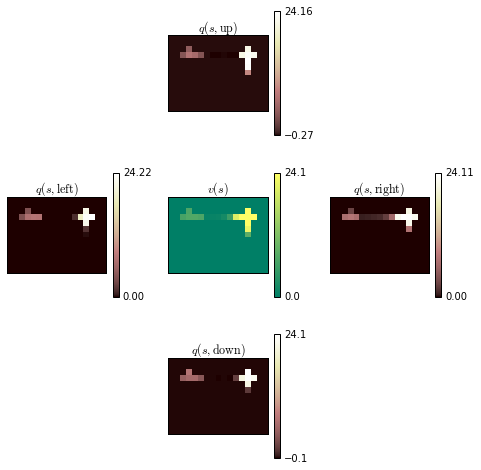

In [57]:
# goal_loc has format (row, col)
tasks = []
for x in xrange(0,10):
  tasks.append(Hallway(goal_loc = (3, 3+x)))

agent = Sarsa(number_of_states=tasks[0]._layout.size,
              number_of_actions=4,
              initial_state=tasks[0].get_obs())

# A. Training on the Longest Hallway Only

  # Should be inside the Task Bandit?
mean_signal, signal_per_episode = run_episode(tasks[-1], agent, number_of_episodes=1)


# B. Manual Curriculum, shortest to longest hallway
mean_signal, signal_per_episode


# C. Uniform Sampling

# D. Graves Bandit

# E. RL for Curriculum Selection



run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

In [58]:
vision_size = 1
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

KeyboardInterrupt: 

In [ ]:
vision_size = 2
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)